# **Vision Transformer Paper Replication Notebook**
Welcome to the **Vision Transformer Paper Replication Notebook**.  

This notebook is part of my learning journey in deep learning and computer vision. It focuses on replicating and understanding the machine learning research paper, **"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"**, which introduces the Vision Transformer (ViT) architecture.  

### **Contents**:  
1. **Setup**: Install and configure the required libraries and dependencies, including `torch`, `torchvision`, and custom utility scripts.  
2. **Data Preparation**: Load the dataset for image classification (pizza, steak, sushi) and prepare it for training.  
3. **Model Replication**: Recreate the Vision Transformer (ViT) model step-by-step, from patch embedding to multi-head attention and transformer encoders.  
4. **Training and Testing**: Train the model on a small dataset, visualize the results, and evaluate the performance.  
5. **Experimentation**: Compare results with pretrained models from `torchvision` and discuss improvements or limitations.  

This notebook not only aims to reproduce the ViT architecture but also provides a clear, modular, and reusable implementation in PyTorch, following good coding practices. It demonstrates my ability to understand and implement cutting-edge machine learning research and adapt it to practical problems like food image classification.

---
This project was inspired by [Daniel Bourke's Vision Transformer tutorial](https://github.com/mrdbourke). His comprehensive guide provided a solid foundation for understanding and implementing the ViT architecture. Special thanks to Daniel for sharing his knowledge and resources.


## 1. Getting Setup
These code blocks ensures your environment is correctly set up for the rest of the notebook.


### 1.1 Check and install the correct versions of PyTorch and torchvision


In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


### 1.2 Install the torchinfo package

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


[INFO] Couldn't find torchinfo... installing it.


### 1.3 Download necessary files from the GitHub repository


In [ ]:
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .  # Prendere il file helper_functions.py
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


### 1.4 Ensure GPU is enabled and available

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


### 1.5 Import main libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


### 1.6 Verify setup


In [ ]:
print("\n[INFO] Setup completed successfully. You're ready to proceed!")
print(f"Device: {device}")


[INFO] Setup completed successfully. You're ready to proceed!
Device: cuda


### 1.7 Download the pizza, steak, and sushi image dataset using the helper function


In [ ]:
from helper_functions import download_data

# Define the source URL and the destination directory
dataset_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
destination_dir = "pizza_steak_sushi"

# Use the download_data function to download the dataset
image_path = download_data(source=dataset_url, destination=destination_dir)

# Verify the dataset path
print(f"Dataset downloaded and available at: {image_path}")


[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
Dataset downloaded and available at: data/pizza_steak_sushi


### 1.8 Set up directory paths for training and testing images


In [ ]:
from pathlib import Path

train_dir = image_path / "train"
test_dir = image_path / "test"

# Output the paths to confirm
print(f"Training directory: {train_dir}")
print(f"Testing directory: {test_dir}")

Training directory: data/pizza_steak_sushi/train
Testing directory: data/pizza_steak_sushi/test


### 1.9 Prepare transforms for images

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup
import matplotlib.pyplot as plt

# Define image size as per the ViT paper (Table 3)
IMG_SIZE = 224

# Create manual transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to 224x224
    transforms.ToTensor()  # Convert image to tensor
])

# Confirm the transformation pipeline
print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 1.10 Turn images into DataLoaders

In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

# Confirm DataLoaders and class names
print(f"Class names: {class_names}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

Class names: ['pizza', 'steak', 'sushi']
Number of training batches: 8
Number of testing batches: 3


### 1.11 Visualize a single image

Image shape: torch.Size([3, 224, 224])
Label: 2 (sushi)


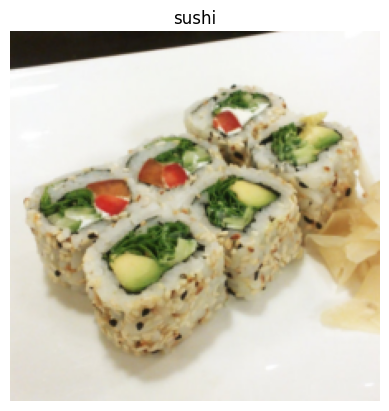

In [ ]:
# Get a batch of images from the DataLoader
image_batch, label_batch = next(iter(train_dataloader))

# Extract a single image and its label from the batch
image, label = image_batch[0], label_batch[0]

# View the shapes of the image and label
print(f"Image shape: {image.shape}")
print(f"Label: {label} ({class_names[label]})")

# Plot the image with its label using matplotlib
plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions for matplotlib
plt.title(class_names[label])  # Set the title to the class name
plt.axis(False)  # Turn off axes
plt.show()

## 2. Replicate the ViT architecture we created with in-built PyTorch transformer layers.



### 2.1The ViT architecture is comprised of several stages:

- **Patch** + **Position Embedding** (*inputs*): Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
- **Linear projection of flattened patches** (*Embedded Patches*): The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
- **Norm**: This is short for "*Layer Normalization*" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.
- **Multi-Head Attention**: This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.
- **MLP** (or *Multilayer perceptron*): A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them (section 3.1) and a `torch.nn.Dropout()` layer after each (Appendix B.1).
- **Transformer Encoder**: The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- **MLP Head**: This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

###2.2 Exploring the Four Equations



#### 2.2.1 **Equation 1**
*testo in corsivo*$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$
In vector form, the embedding might look something like:

```
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```



#### 2.2.2 **Equation 2**

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$
In pseudocode, this might look like:
```
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```



#### 2.2.3 **Equation 3**

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\ \end{aligned} $$

In pseudocode, this might look like:
```
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```



#### 2.2.4 **Equation 4**

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

In pseudocode, this might look like:
```
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```



## 3. Equation 1: Split data into patches and creating the class, position and patch embedding



### 3.1 Define variables based on the ViT paper


In [ ]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### 3.2 Turning a single image into patches

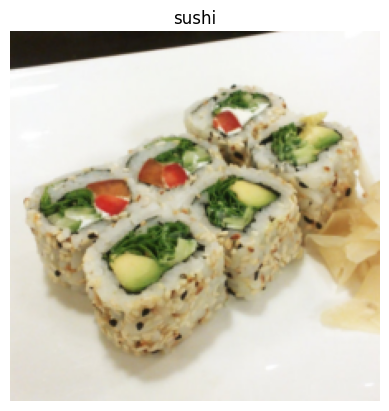

In [ ]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)
# View single image
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False);

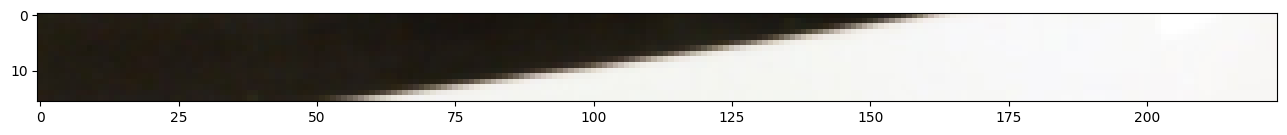

In [ ]:
# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


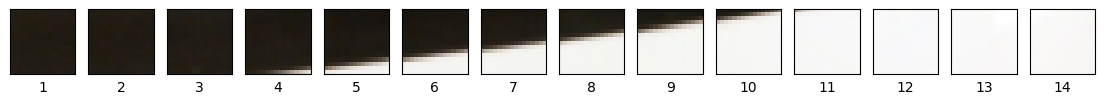

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size//patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=num_patches, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


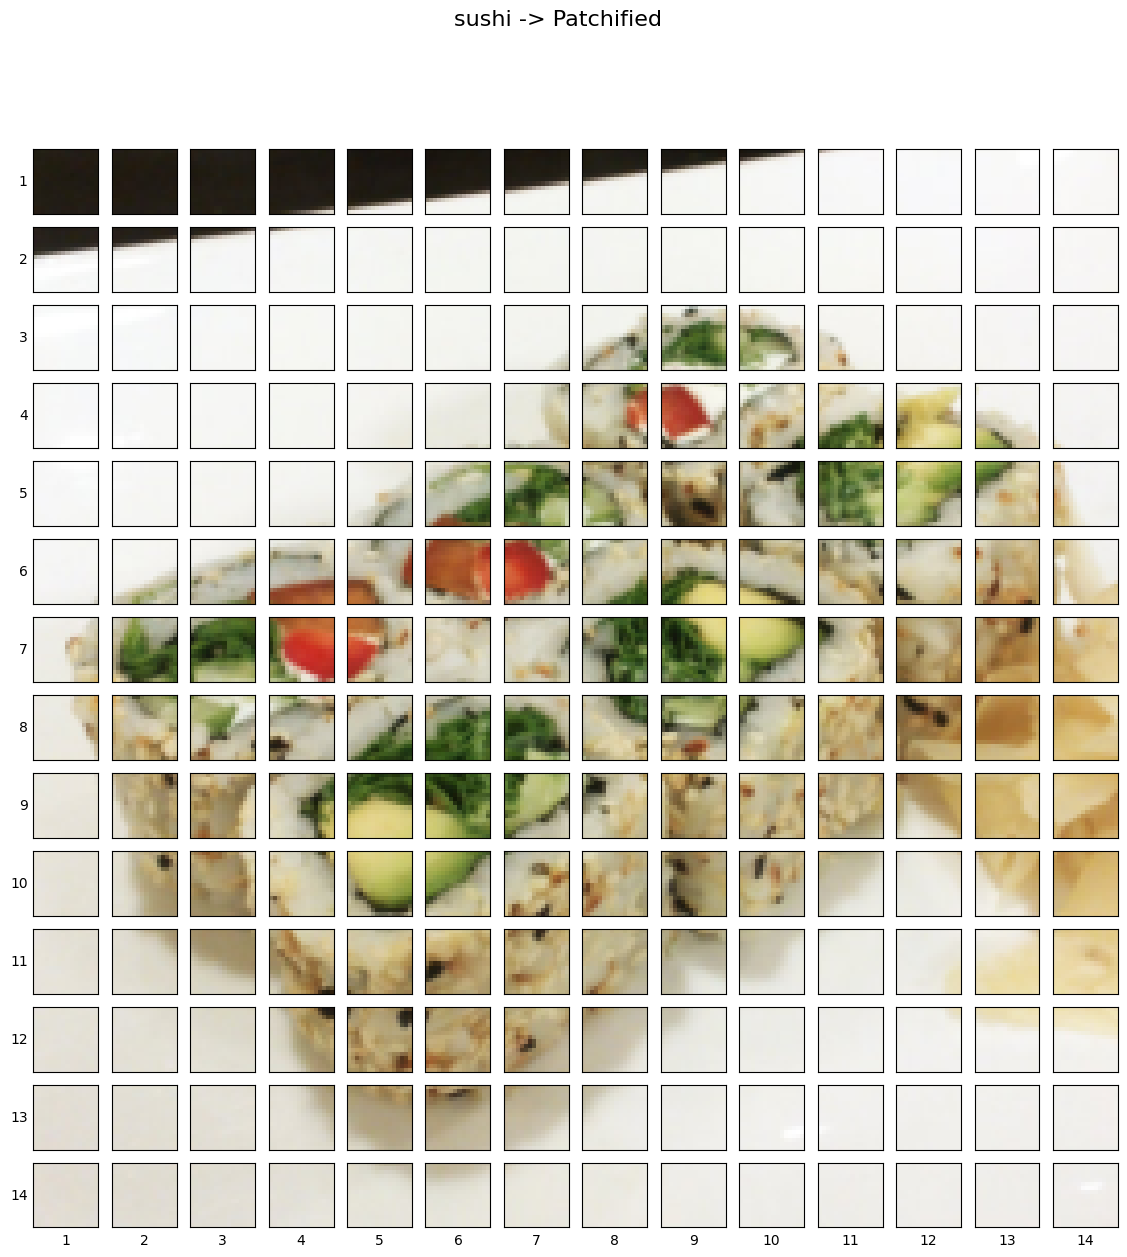

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 3.3 Creating image patches with torch.nn.Conv2d()


In [ ]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

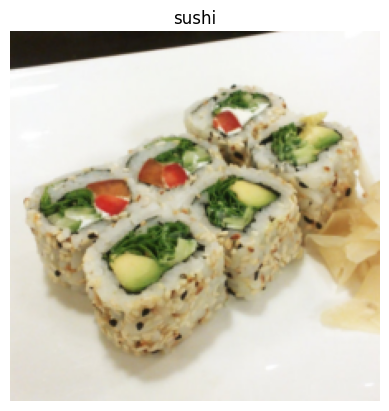

In [ ]:
# View single image
plt.imshow(image_permuted)
plt.title(class_names[label])
plt.axis(False);

In [ ]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


The "feature map" they're referring to are the weights/activations produced by a convolutional layer passing over a given image.

Let's visualize five random feature maps and see what they look like.


Showing random convolutional feature maps from indexes: [57, 584, 730, 548, 511]


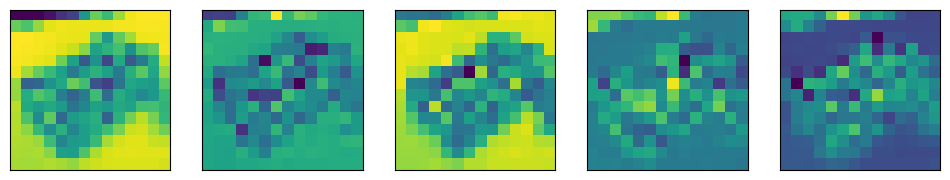

In [ ]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

### 3.4 Flattening the patch embedding with torch.nn.Flatten()



In [ ]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


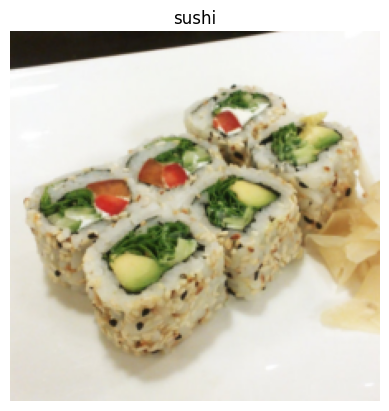

In [ ]:
# 1. View single image
plt.imshow(image_permuted) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

It looks like our image_out_of_conv_flattened shape is very close to our desired output shape:
- Desired output (flattened 2D patches): (196, 768) -> ${N \times\left(P^{2} \cdot C\right)}$

- Current shape: (1, 768, 196)


In [ ]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


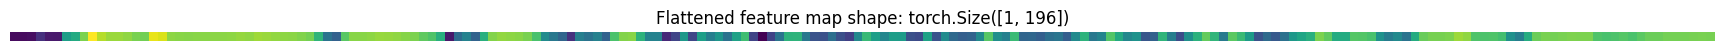

In [ ]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

Each of the 196 features has 768 dims

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.0596, 0.0586, 0.0632, 0.1356, 0.0890, 0.0841, 0.4192, 0.4556, 0.5848,
          0.7193, 0.6429, 0.6171, 0.6160, 0.6055, 0.5814, 0.5745, 0.6974, 0.6813,
          0.6047, 0.5984, 0.5952, 0.5980, 0.5989, 0.6007, 0.6013, 0.6036, 0.6116,
          0.6065, 0.6220, 0.6160, 0.6095, 0.6028, 0.6000, 0.5907, 0.5777, 0.4850,
          0.2990, 0.2491, 0.5440, 0.5978, 0.5994, 0.6031, 0.6144, 0.6118, 0.6055,
          0.5954, 0.5857, 0.5539, 0.5321, 0.4667, 0.0851, 0.2777, 0.3401, 0.2547,
          0.4675, 0.5925, 0.6082, 0.6048, 0.5982, 0.5821, 0.5245, 0.3662, 0.3110,
          0.2610, 0.1368, 0.3312, 0.2966, 0.3376, 0.2536, 0.5266, 0.5937, 0.5985,
          0.4791, 0.3391, 0.3406, 0.1162, 0.1793, 0.4012, 0.1831, 0.4221, 0.3303,
          0.3963, 0.2953, 0.4276, 0.5117, 0.1768, 0.0385, 0.1744, 0.3007, 0.4785,
          0.4823, 0.3105, 0.2117, 0.2069, 0.2859, 0.2061, 0.1686, 0.3570, 0.4993,
          0.4191, 0.3509, 0.4165, 0.4146, 0.2056, 0.1917, 0.4320, 0.2118, 0.3666,
          0.2722

###3.5 Turning the ViT patch embedding layer into a PyTorch module


Put everything into a single PyTorch layer using subclassing nn.Module and creating a small PyTorch "model" to do all of the steps above.

Specifically:

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture (${N \times\left(P^{2} \cdot C\right)}$).

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

PatchEmbedding layer created!

Let's try it out on a single image.



In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


The output shape matches the ideal input and output shapes we'd like to see from the patch embedding layer:

- Input: The image starts as 2D with size ${H \times W \times C}$.
- Output: The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

Where:

- $(H, W)$ is the resolution of the original image.
- $C$ is the number of channels.
- $(P, P)$ is the resolution of each image patch (patch size).
- $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
       input_size=random_input_image, # try swapping this for "random_input_image_error"
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### 3.6 Creating the class token embedding


In [ ]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.1331,  0.0233, -0.0666,  ...,  0.0949, -0.0628,  0.0494],
         [-0.1237,  0.0164, -0.0620,  ...,  0.0955, -0.0516,  0.0445],
         [-0.1311,  0.0144, -0.0591,  ...,  0.0949, -0.0584,  0.0541],
         ...,
         [-0.9721,  0.2644, -0.2679,  ...,  0.7361, -0.4419,  0.3437],
         [-0.9678,  0.2605, -0.2678,  ...,  0.7336, -0.4428,  0.3425],
         [-0.9863,  0.2679, -0.2609,  ...,  0.7423, -0.4381,  0.3313]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]



To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension ($D$) and then add it to the number_of_patches dimension.

Or in pseudocode:


```
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)

```



Let's create a learnable embedding for the class token.

To do so, we'll get the batch size and embedding dimension shape and then we'll create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]`.

And we'll make the tensor learnable by passing it to `nn.Parameter()` with `requires_grad=True`.

In [ ]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> **Note**: Here we're only creating the class token embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the class token embedding with `torch.randn()` (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

See how the number_of_tokens dimension of class_token is 1 since we only want to prepend one class token value to the start of the patch embedding sequence.


Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image.

We can do so using `torch.cat()` and set dim=1 (so class_token's number_of_tokens dimension is prepended to patch_embedded_image's number_of_patches dimension).

In [ ]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1331,  0.0233, -0.0666,  ...,  0.0949, -0.0628,  0.0494],
         [-0.1237,  0.0164, -0.0620,  ...,  0.0955, -0.0516,  0.0445],
         ...,
         [-0.9721,  0.2644, -0.2679,  ...,  0.7361, -0.4419,  0.3437],
         [-0.9678,  0.2605, -0.2678,  ...,  0.7336, -0.4428,  0.3425],
         [-0.9863,  0.2679, -0.2609,  ...,  0.7423, -0.4381,  0.3313]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]




> Note: the first row of the tensor contains only values equal to 1.0. This represents the class token (class_token) added to the beginning of the sequence (`torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]`)


### 3.7 Creating the position embedding



To start creating the position embeddings, let's view our current embeddings.



In [ ]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1331,  0.0233, -0.0666,  ...,  0.0949, -0.0628,  0.0494],
          [-0.1237,  0.0164, -0.0620,  ...,  0.0955, -0.0516,  0.0445],
          ...,
          [-0.9721,  0.2644, -0.2679,  ...,  0.7361, -0.4419,  0.3437],
          [-0.9678,  0.2605, -0.2678,  ...,  0.7336, -0.4428,  0.3425],
          [-0.9863,  0.2679, -0.2609,  ...,  0.7423, -0.4381,  0.3313]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

So let's make a learnable 1D embedding with torch.ones() to create $\mathbf{E}_{\text {pos }}$.

In [ ]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> **Note**: Only creating the position embedding as `torch.ones()` for demonstration purposes, in reality, you'd likely create the position embedding with `torch.randn()` (start with a random number and improve via gradient descent).

Position embeddings created!

Let's add them to our sequence of patch embeddings with a prepended class token.

In [ ]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8669, 1.0233, 0.9334,  ..., 1.0949, 0.9372, 1.0494],
         [0.8763, 1.0164, 0.9380,  ..., 1.0955, 0.9484, 1.0445],
         ...,
         [0.0279, 1.2644, 0.7321,  ..., 1.7361, 0.5581, 1.3437],
         [0.0322, 1.2605, 0.7322,  ..., 1.7336, 0.5572, 1.3425],
         [0.0137, 1.2679, 0.7391,  ..., 1.7423, 0.5619, 1.3313]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


###3.8 Putting it all together: from image to embedding



In [ ]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


## 4. Equation 2: Multi-Head Attention (MSA)



###4.1 The LayerNorm (LN) layer
Layer Normalization (`torch.nn.LayerNorm()` or Norm or LayerNorm or LN) normalizes an input over the last dimension.

###4.2 The Multi-Head Self Attention (MSA) layer

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

- embed_dim: the embedding dimension from Table 1 (Hidden size $D$).
- num_heads: how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
- dropout: whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
- batch_first: does our batch dimension come first? (yes it does)

###4.3 Replicating Equation 2 with PyTorch layers

To do so, we'll:

- Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
- Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
- Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension ($D$ from Table 1).
- Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
- Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.


In [ ]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


##5. Equation 3: Multilayer Perceptron (MLP)



###5.1 The MLP layer(s)
The structure of our MLP block will be:

layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size $D$ is the output size of the MLP block).

###5.2 Replicating Equation 3 with PyTorch layers

To do so, we'll:

1. Create a class called MLPBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the normalized_shape parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a sequential series of MLP layers(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [ ]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Let's try it out by create an instance of our MLPBlock and passing through the patched_image_through_msa_block variable we created

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


##6. Create the Transformer Encoder

###6.1 Creating a Transformer Encoder by combining our custom made layers
To do so, we'll:

1. Create a class called TransformerEncoderBlock that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a `forward()` method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [ ]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

Transformer Encoder block created!



In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
# summary(model=transformer_encoder_block,
#         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

###6.2 Creating a Transformer Encoder with PyTorch's Transformer layers

In [ ]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

To inspect it further, let's get a summary with torchinfo.summary().

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

##7. Putting it all together to create ViT

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

🕺💃🥳 Woohoo!!! We just built a vision transformer!


In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


Notice how the first dimension gets expanded to the batch size and the other dimensions stay the same (because they're inferred by the "-1" dimensions in .expand(batch_size, -1, -1)).

Alright time to test out ViT() class.

Let's create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens.

In [ ]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

##7.1 Getting a visual summary of our ViT model

In [ ]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
ViT (ViT)                                                    [32, 3, 224, 224]
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]
│    └─Flatten (flatten)                                     [32, 768, 14, 14]
├─Dropout (embedding_dropout)                                [32, 197, 768]
├─Sequential (transformer_encoder)                           [32, 197, 768]
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]
│    │    └─MLPBlock (mlp_block)                             [32, 197, 768]
│    └─TransformerEncoderBlock (1)                           [32, 197, 768]
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]
│    │    └─MLPBlock (mlp_block)                             [32, 197, 768]
│  

##8. Setting up training code for our ViT model

We'll start by importing the engine.py script from going_modular.going_modular then we'll setup the optimizer and loss function and finally we'll use the train() function from engine.py to train our ViT model for 10 epochs (we're using a smaller number of epochs than the ViT paper to make sure everything works).

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1949 | train_acc: 0.3633 | test_loss: 5.1213 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.9517 | train_acc: 0.3320 | test_loss: 1.6205 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2073 | train_acc: 0.4570 | test_loss: 1.7585 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2482 | train_acc: 0.2969 | test_loss: 1.3214 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1331 | train_acc: 0.4297 | test_loss: 1.2293 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.1787 | train_acc: 0.3125 | test_loss: 1.2245 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.2512 | train_acc: 0.2578 | test_loss: 1.2060 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1147 | train_acc: 0.4258 | test_loss: 1.1859 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1458 | train_acc: 0.3047 | test_loss: 1.0135 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2647 | train_acc: 0.2617 | test_loss: 1.3921 | test_acc: 0.2604


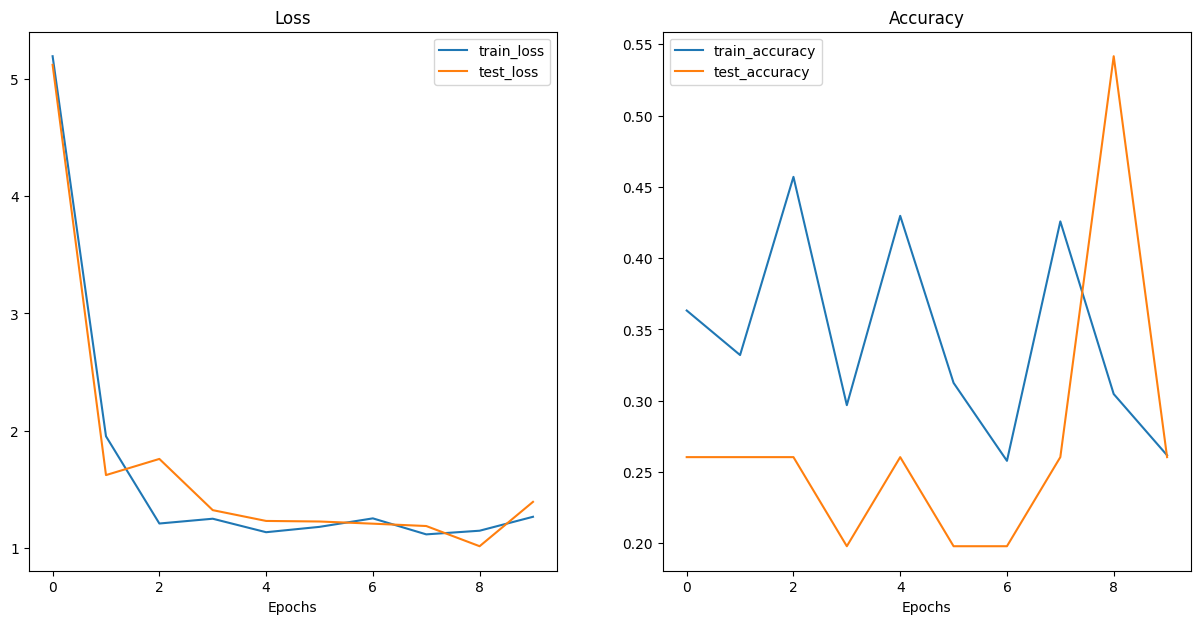

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

##9. Using a pretrained ViT from torchvision.models on the same dataset



In [ ]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 163MB/s]


In [ ]:
# # Print a summary using torchinfo (uncomment for actual output)
# summary(model=pretrained_vit,
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

###9.2 Preparazione dei dati per il modello ViT pre-addestrato



In [ ]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


###9.3 Modello ViT dell'estrattore di funzionalità del treno

In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


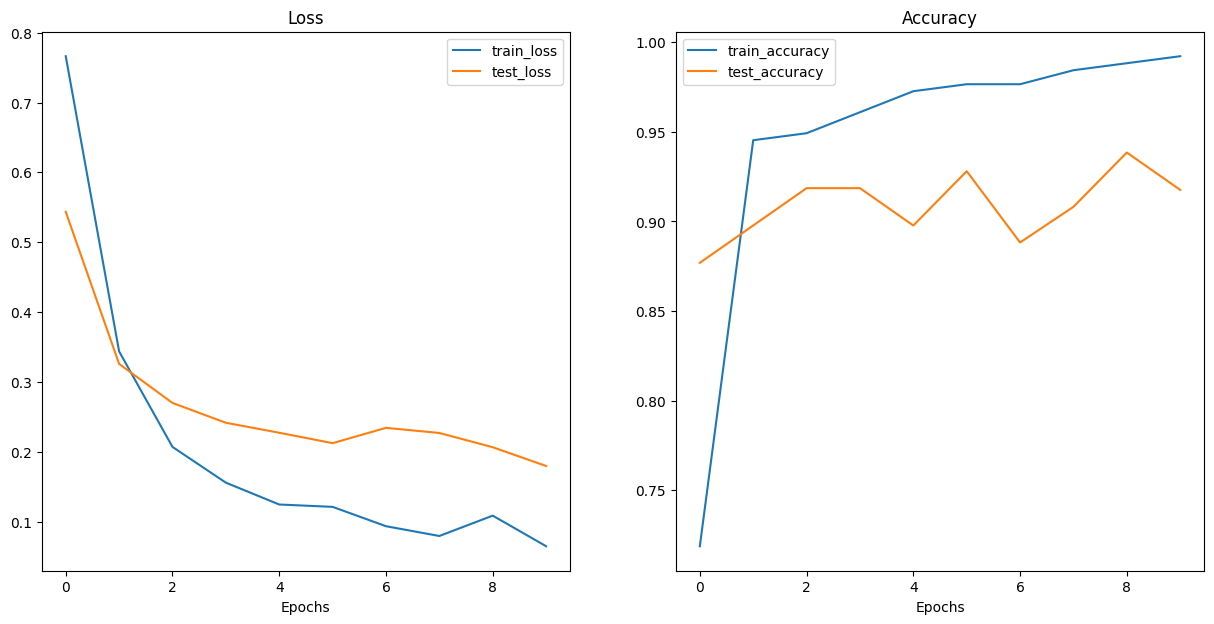

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


##10. Make predictions on a custom image

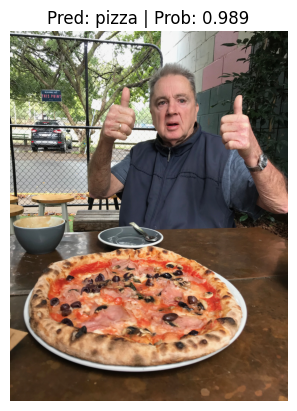

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)